In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import os
import sys
import importlib.util

current_working_directory = os.getcwd()
# Go one directory back
parent_directory = os.path.dirname(current_working_directory)

# Construct the path to the module, assuming the module is in the parent directory
takahashi_module_path = os.path.join(parent_directory, "takahashi_loader.py")
# Load the module
spec = importlib.util.spec_from_file_location("takahashi_loader", takahashi_module_path)
takahashi_loader = importlib.util.module_from_spec(spec)
sys.modules["takahashi_loader"] = takahashi_loader
spec.loader.exec_module(takahashi_loader)

# Construct the path to the module, assuming the module is in the parent directory
calculations_module_path = os.path.join(parent_directory, "calculations_module.py")
# Load the module
spec = importlib.util.spec_from_file_location("calculations_module", calculations_module_path)
calculations_module = importlib.util.module_from_spec(spec)
sys.modules["calculations_module"] = calculations_module
spec.loader.exec_module(calculations_module)

import re


In [2]:
def get_l1_from_map(map, thresholds_snr):
    snr = map 
    # thresholds_snr = np.linspace(np.min(snr), np.max(snr), nbins + 1)
    bins_snr = 0.5 * (thresholds_snr[:-1] + thresholds_snr[1:])
    digitized = np.digitize(snr, thresholds_snr)
    bin_l1_norm = [np.sum(np.abs(snr[digitized == i]))
                    for i in range(1, len(thresholds_snr))]
    return bins_snr, bin_l1_norm

def extract_and_convert_array(content, key):
    pattern = rf'- {key}: \[([-\d.e\s]+)\]'
    match = re.search(pattern, content)
    if match:
        array_string = match.group(1)
        return [float(value) for value in array_string.split() if value]
    return []

In [3]:
# Redshift values for Takahashi simulation
tk_zs = np.array([0.0506, 0.5078, 1.0334, 1.2179, 1.4230, 1.6528, 1.9121, 2.0548, 2.3704, 3.9309, 5.3423])


zs_ = [tk_zs[7]]

theta1_input_ = [15., 18, 20]

In [5]:
for zs_counter in range(len(zs_)):
    for theta1_counter in range(len(theta1_input_)-2):
        zs = zs_[zs_counter]
        theta1_input = theta1_input_[theta1_counter]  
        nside = 2048 # HEALPix parameter for angular resolution
        loader = takahashi_loader.TakahashiLoader()

        variance_takahashi, kmap1, kmap2 = loader.run_loader(theta1_input, nside, zs, 8)
        k_massmap_simulation = kmap2 - kmap1

        fullsky_map = k_massmap_simulation
        nside = hp.get_nside(fullsky_map)
        print("NSIDE:", nside)

        degsize = 60
        phi = [35, 45, 55, 85, 97, 103, 156, 225, 275, 315]  # Example phi values
        theta = [35, 45, 55, 85, 97, 103, 126, 225, 315, 275]  # Example theta values (matching the length of phi)

        # Create an array to represent the mask
        mask = np.zeros(hp.nside2npix(nside))

        # Convert pixel indices to spherical coordinates (theta, phi)
        pixel_theta, pixel_phi = np.degrees(hp.pix2ang(nside, np.arange(hp.nside2npix(nside))))

        counts_full, bins_full = np.histogram(fullsky_map,bins=300,density=True)
        bin_centers_full = 0.5*(bins_full[1:]+bins_full[0:-1])
        print(calculations_module.get_moments(bin_centers_full, counts_full), np.max(counts_full), np.var(fullsky_map))

        _, l1_full = get_l1_from_map(fullsky_map, bins_full)

        masks = []

        count = np.zeros((len(phi),len(bin_centers_full)))
        l1 = np.zeros((len(phi),len(bin_centers_full)))
        # Loop through specified regions (phi, theta) and set corresponding pixels in the mask to 1
        for i in range(len(phi)):
            mask = np.zeros(hp.nside2npix(nside))
            mask[(pixel_phi < (phi[i] + degsize / 2) % 360) & (pixel_phi > (phi[i] - degsize / 2) % 360)
                & (pixel_theta < (theta[i] + degsize / 2) % 180) & (pixel_theta > (theta[i] - degsize / 2) % 180)] = 1
                # Flatten the full-sky map and mask
            masks.append(mask)
            
            flat_full_sky_map = fullsky_map.flatten()
            flat_mask = mask.flatten()
            # Create a histogram using only the data within the masked region
            masked_data = flat_full_sky_map[flat_mask == 1]
            
            bins_snr, bin_l1_norm = get_l1_from_map(masked_data,bins_full)
            l1[i,:] = bin_l1_norm
            
            counts, bins = np.histogram(masked_data,bins=bins_full,density=True)
            count[i,:] = counts
            bin_centers = 0.5*(bins[1:]+bins[0:-1])
            print(calculations_module.get_moments(bin_centers, counts), np.max(counts), np.var(masked_data))
        
        # # Plot the full-sky map and the masked map
        # hp.mollview(fullsky_map, title='Original Full-Sky Map', cmap='viridis')
        # plt.show()

        num_masks = len(phi)
        num_rows = 2
        # Calculate the number of rows needed
        # num_cols = int(np.ceil(num_masks / num_rows))
        # for i in range(len(phi)):
            
        #     hp.mollview(masks[i], title= str(phi[i]) + " " + str(theta[i]), cmap='viridis', sub=(num_rows, num_cols, i+1), max=1)
            
        # Format zs similar to how you did when saving the file
        zs_formatted = str(zs).replace('.', '_')
        # Construct the filename using the formatted zs and theta1_input
        filename_theory = f"theory_values_{zs_formatted}_{theta1_input}"
        filename_simulation = f"simulation_values_{zs_formatted}_{theta1_input}"

        parent_directory= "/feynman/work/dap/lcs/vt272285/codes/LDT_Map_PDF/paper/data/"
        # Construct the file path
        file_path = parent_directory +  f"{filename_theory}"
        content_theory = np.load(filename_theory + ".npy")
        # if os.path.exists(file_path):
        #     # Open the file and read its content
        #     with open(file_path, "r") as file:
        #         content = file.read()
        #         # Print or process the content as needed
        #         print("File content loaded successfully:")
        # else:
        #     print(f"File {file_path} does not exist.")
            
        kappa_prediction = content_theory[2]
        l1_prediction = content_theory[1]
        plt.figure(figsize=(8,4))    
        l1_ = np.zeros_like(l1)
        for i in range(l1.shape[0]):
            tot_pix = np.sum(masks[i])
            factor =  (12*nside*nside)
            l1_[i] = l1[i]/tot_pix / (bin_centers_full[1]-bin_centers_full[0])
            plt.plot(bin_centers_full, l1_[i], alpha=0.2,c='b')
        plt.plot(bin_centers_full , np.array(l1_full),c='k',ls=":")
        plt.errorbar(bin_centers_full, np.average(l1_, axis=0), yerr= np.std(l1_, axis=0),color='red',alpha=0.3)
        plt.xlim(-0.01,0.01)
        theory_factor = factor*(kappa_prediction[1]-kappa_prediction[0])
        plt.plot(kappa_prediction,np.array(l1_prediction),c='orange')
            
        kappa_sim =  bin_centers.reshape(1, l1_.shape[1])
        l1_sim_full = np.array(l1_full).reshape(1, l1_.shape[1])
        sim_vals =  np.vstack((l1_, l1_sim_full, kappa_sim))
        file_path_sim = parent_directory +  f"{filename_simulation}"
        np.save(file_path_sim, sim_vals.T)
        print(" ")

the source redshift for which the file is being loaded is:  2.0548
the takahashi file being loaded is:  /feynman/work/dap/lcs/vt272285/data/sim_data/Takahashi/allskymap_nres12r000.zs25.mag.dat
nside:4096 npix:201326592
file opened!
Smoothing operations done!
The redshift is: 2.0548
The theta is: 15.0
Variance: 2.9103673576397647e-05
NSIDE: 2048
(3.1507908186808806e-09, 2.910847386402189e-05, -42.083718284357126, 0.2775862056135576, 0.9999999304612478) 75.53630915385774 2.9103673576397647e-05
(2.6119832239105117e-07, 2.8548986093089974e-05, -43.149512611939144, 0.3609464700259797, 0.9999999999999999) 76.55215689824627 2.8544331930774855e-05
(1.3023519832746483e-06, 2.8901851189881776e-05, -43.08881244973527, 0.2878891922907916, 1.0) 76.19571312948744 2.8897237107890008e-05
(-2.4016020230823386e-06, 2.9451276953737884e-05, -44.59396255605682, 0.32101168433010274, 1.0) 75.53770373321404 2.9446783214980537e-05
(-3.983142282712812e-06, 2.9238752221345346e-05, -43.0504119331362, 0.2632017826

FileNotFoundError: [Errno 2] No such file or directory: 'theory_values_2_0548_15.0.npy'

(-2.5, 2.5)

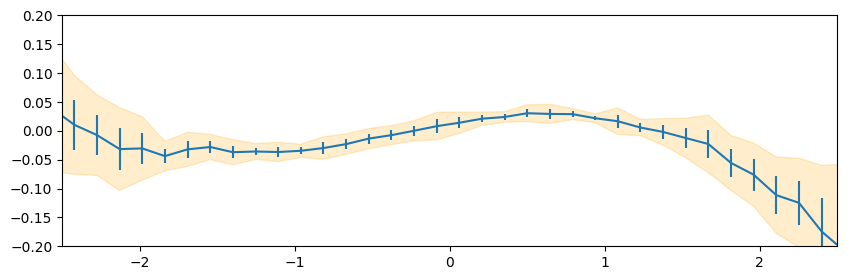

In [57]:
l1_simulation_data = np.load(file_path_sim+".npy")
l1_simulation_data = l1_simulation_data.T
prediction_factor = factor*(kappa_prediction[1]-kappa_prediction[0])

l1_theory = np.array(l1_prediction)
mean_l1_simulation_data = np.mean(l1_simulation_data[0:9], axis=0)
non_zero_indices = np.where(mean_l1_simulation_data != 0)[0]  # Indices where mean is not zero

# Filter based on non-zero mean for calculations
x_filtered = l1_simulation_data[11][non_zero_indices] / np.sqrt(1.0973913836022046e-05)
y_filtered = (mean_l1_simulation_data[non_zero_indices] - (l1_theory[non_zero_indices])) / mean_l1_simulation_data[non_zero_indices]
yerr_filtered = np.std(l1_simulation_data[0:9], axis=0)[non_zero_indices] / mean_l1_simulation_data[non_zero_indices]

# Further select every third point from the filtered data
x_subset = x_filtered[::3]
y_subset = y_filtered[::3]
yerr_subset = yerr_filtered[::3]

# Calculate bounds for visualization
lower_bound_l1 = y_subset -3.*yerr_subset
upper_bound_l1 = y_subset + 3.*yerr_subset

plt.figure(figsize=(10,3)) 
plt.errorbar(x_subset, y_subset, yerr=yerr_subset)
plt.fill_between(x_subset, lower_bound_l1, upper_bound_l1, color='orange', alpha=0.2)
plt.ylim(-0.2, 0.2)
plt.xlim(-2.5, 2.5)
